# Modelo de riesgo de crédito
### Amilder Stewin Ospina Tobon
### Daniel Torres Aguirre
### Wilmar Andres Garcia Bedoya

## Introducción

En este documento examinaremos las variables necesarias para asignar un puntaje de riesgo de acuerdo al historial crediticio, y como estos puntajes de riesgos influyen en si se concede un préstamo o no.

se toman en cuenta diferentes factores como: cumplimiento de pago de cuotas, endeudamiento entre otros 

## Objetivo

- Crear y validar un modelo de probabilidad de incumplimiento   

- Representar el modelo en una scorecard 

- Analizar que variables hacen mas riesgosa a una persona 

# Carga y limpieza de datos

In [1]:
# import the required libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, precision_recall_curve, auc
from sklearn.feature_selection import f_classif
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from scipy.stats import chi2_contingency

In [2]:
#from google.colab import drive
#drive.mount('/content/drive')

In [3]:
#loan_data = pd.read_csv('/content/drive/Shareddrives/TAE 2022-2/Trabajo 2/loan_data_2007_2014.csv')
loan_data = pd.read_csv('/datasets/loandata/loan_data_2007_2014.csv')
print(loan_data.head())

/shared-libs/python3.9/py-core/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3139: DtypeWarning: Columns (19) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
        id  member_id  loan_amnt  funded_amnt  funded_amnt_inv        term  \
0  1077501    1296599       5000         5000           4975.0   36 months   
1  1077430    1314167       2500         2500           2500.0   60 months   
2  1077175    1313524       2400         2400           2400.0   36 months   
3  1076863    1277178      10000        10000          10000.0   36 months   
4  1075358    1311748       3000         3000           3000.0   60 months   

   int_rate  installment grade sub_grade  ... total_bal_il il_util  \
0     10.65       162.87     B        B2  ...          NaN     NaN   
1     15.27        59.83     C        C4  ...          NaN     NaN   
2     15.96        84.33     C        C5  ...          Na

Eliminamos las columnas que tienen más del 80% de los datos en nulo

In [4]:
loan_data.dropna(thresh = loan_data.shape[0]*0.2, how = 'all', axis = 1, inplace = True)

Eliminamos todas las columnas con informacion redundante o que no esten relacionadas con el riesgo de credito 

In [5]:
loan_data.drop(columns = ['id', 'member_id', 'sub_grade', 'emp_title', 'url', 'desc', 'title',
                          'zip_code', 'next_pymnt_d', 'recoveries', 'collection_recovery_fee',
                          'total_rec_prncp', 'total_rec_late_fee'], inplace = True)

Se necesita realizar un data cleaning, se requiere que las variables emp_length y term sean llevados a tipo numerico, ademas de las variables que tengan datos de fechas llevarlas al formato de fecha python 

In [6]:
#limpieza de la columna emp_length, asignacion de NAN a 0's y conversion a numerico
loan_data['emp_length'] = loan_data['emp_length'].str.replace('\+ years', '')
loan_data['emp_length'] = loan_data['emp_length'].str.replace('< 1 year', str(0))
loan_data['emp_length'] = loan_data['emp_length'].str.replace(' years', '')
loan_data['emp_length'] = loan_data['emp_length'].str.replace(' year', '')
loan_data['emp_length'] = pd.to_numeric(loan_data['emp_length'])
loan_data['emp_length'].fillna(value = 0, inplace = True)

#eliminacion de 'months' de la columna term y conversion a numericos 
loan_data['term'] = pd.to_numeric(loan_data['term'].str.replace(' months', ''))


#funcion creada para asignar el formato de fecha datatime de python
def date_columns(df, column):
    # store current month
    today_date = pd.to_datetime('2020-08-01')
    # convert to datetime format
    df[column] = pd.to_datetime(df[column], format = "%b-%y")
    # calculate the difference in months and add to a new column
    df['mths_since_' + column] = round(pd.to_numeric((today_date - df[column]) / 
							np.timedelta64(1, 'M')))
    # make any resulting -ve values to be equal to the max date
    df['mths_since_' + column] = df['mths_since_' + column].apply(
		lambda x: df['mths_since_' + column].max() if x < 0 else x)
    # drop the original date column
    df.drop(columns = [column], inplace = True)

date_columns(loan_data, 'earliest_cr_line')
date_columns(loan_data, 'issue_d')
date_columns(loan_data, 'last_pymnt_d')
date_columns(loan_data, 'last_credit_pull_d')



/tmp/ipykernel_334/2678454746.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  loan_data['emp_length'] = loan_data['emp_length'].str.replace('\+ years', '')


# Selección de variables 

## Variable objetivo

In [7]:
#exploramos los valores unicos de loan_status para poder definir nuestra variable objetivo
loan_data['loan_status'].value_counts(normalize = True)

Current                                                0.480878
Fully Paid                                             0.396193
Charged Off                                            0.091092
Late (31-120 days)                                     0.014798
In Grace Period                                        0.006747
Does not meet the credit policy. Status:Fully Paid     0.004263
Late (16-30 days)                                      0.002612
Default                                                0.001784
Does not meet the credit policy. Status:Charged Off    0.001632
Name: loan_status, dtype: float64

La variable loan_status cuenta con los valores 


*   Current
*   Fully
*   Late (31-120 days) 
*   In Grace Period
*   Does not meet the credit policy. Status:Fully Paid
*   Late (16-30 days) 
*   Default
*   Does not meet the credit policy. Status:Charged Off  

Cambiamos la variable de categorica a numerica de la siguiente manera:

Clasificaremos los siguientes elementos como malos cambiando su valor por un '0'

*   Charged Off
*   Default
*   Late (31-120 days)
*   Does not meet the credit policy. Status:Charged Off  

El resto de valores seran considerados como buenos cambiando su valor por un '1'











In [8]:
# se crea en una nueva columna basada en la información anterior, esta sera nuestra variable objetivo
loan_data['good_bad'] = np.where(loan_data.loc[:, 'loan_status'].isin(['Charged Off', 'Default',
                                                                       'Late (31-120 days)',
                                                                       'Does not meet the credit policy. Status:Charged Off']),
                                 0, 1)
# se elimina la columna original
loan_data.drop(columns = ['loan_status'], inplace = True)

Se hace un split de los datos en 80-20 para los datos de entrenamiento y de validacion

In [9]:
X = loan_data.drop('good_bad', axis = 1)
y = loan_data['good_bad']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, 
                                                    random_state = 42, stratify = y)

X_train, X_test = X_train.copy(), X_test.copy()

Para la seleccion de variables, las cuales seran consideradas las mas adecuadas para nuestro problema de clasificacion, usaremos la prueba de Chi-Cuadrado para las variables categoricas y el estadistico F de Anova para las variables numericas 

## Prueba de Chi-Cuadrado para las variables categoricas

In [10]:
#dividimos los datos de entrenamiento en categoricos y numericos
X_train_cat = X_train.select_dtypes(include = 'object').copy()
X_train_num = X_train.select_dtypes(include = 'number').copy()

#Se crea un diccionario para guardar los resultados de la prueba de chi-cuadrado
chi2_check = {}

#Calculo del chi-cuadrado para cada columna usando la variable objetivo 
for column in X_train_cat:
    chi, p, dof, ex = chi2_contingency(pd.crosstab(y_train, X_train_cat[column]))
    chi2_check.setdefault('Feature',[]).append(column)
    chi2_check.setdefault('p-value',[]).append(round(p, 10))

#Se convierte el diccionario en un data frame
chi2_result = pd.DataFrame(data = chi2_check)
chi2_result.sort_values(by = ['p-value'], ascending = True, ignore_index = True, inplace = True)

## Estadistico F de ANOVA para las variables numericas

In [11]:
#Ya que la funcion f_class_if no acepta valores N/A los rellenaremos con la media
X_train_num.fillna(X_train_num.mean(), inplace = True)

#Calculo del F estadistico y sus correspondientes valores P
F_statistic, p_values = f_classif(X_train_num, y_train)

#Convertir a data frame
ANOVA_F_table = pd.DataFrame(data = {'Numerical_Feature': X_train_num.columns.values,
					'F-Score': F_statistic, 'p values': p_values.round(decimals=10)})
ANOVA_F_table.sort_values(by = ['F-Score'], ascending = False, ignore_index = True, inplace = True)

top_num_features = ANOVA_F_table.iloc[:20,0].to_list()
top_num_features
#pero bueno mientras podamos editar en celdas diferentes
#sí, va mucho mejor

/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:110: UserWarning: Features [25] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:111: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


['mths_since_last_pymnt_d',
 'total_pymnt_inv',
 'total_pymnt',
 'int_rate',
 'last_pymnt_amnt',
 'out_prncp',
 'out_prncp_inv',
 'mths_since_last_credit_pull_d',
 'mths_since_issue_d',
 'inq_last_6mths',
 'term',
 'revol_util',
 'dti',
 'annual_inc',
 'tot_cur_bal',
 'mths_since_earliest_cr_line',
 'total_rev_hi_lim',
 'total_rec_int',
 'total_acc',
 'emp_length']

<AxesSubplot:>

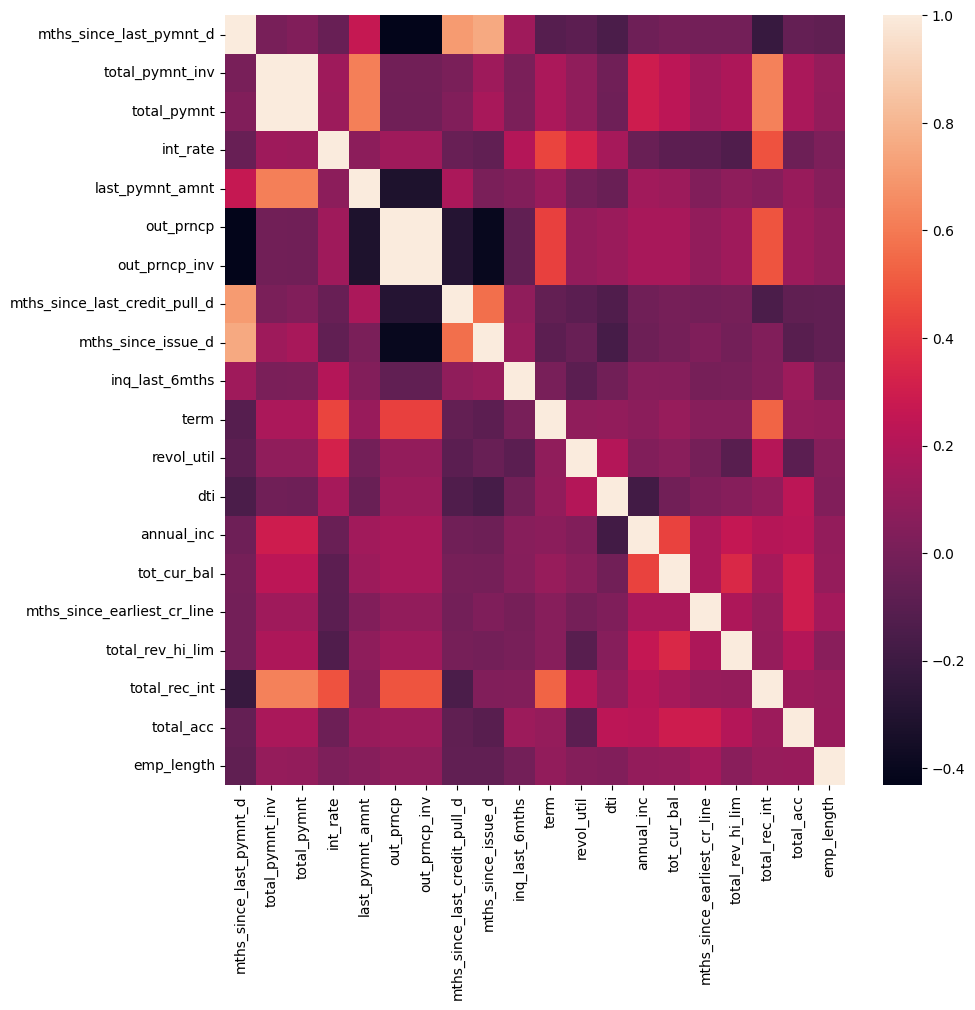

In [12]:
#Matriz de correlaciones para estas variables
corrmat = X_train_num[top_num_features].corr()
plt.figure(figsize=(10,10))
sns.heatmap(corrmat)

In [13]:
#Se guardan los nombres de las columnas para ser eliminados
drop_columns_list = ANOVA_F_table.iloc[20:, 0].to_list()
drop_columns_list.extend(chi2_result.iloc[4:, 0].to_list())
drop_columns_list.extend(['out_prncp_inv', 'total_pymnt_inv'])

#Se borran las columnas 
X_train.drop(columns = drop_columns_list, inplace = True)

In [14]:
# function to create dummy variables
def dummy_creation(df, columns_list):
    df_dummies = []
    for col in columns_list:
        df_dummies.append(pd.get_dummies(df[col], prefix = col, prefix_sep = ':'))
    df_dummies = pd.concat(df_dummies, axis = 1)
    df = pd.concat([df, df_dummies], axis = 1)
    return df

# apply to our final four categorical variables
X_train = dummy_creation(X_train, ['grade', 'home_ownership', 'verification_status', 'purpose'])

X_test.drop(columns = drop_columns_list, inplace = True)
X_test = dummy_creation(X_test, ['grade', 'home_ownership', 'verification_status', 'purpose'])
# reindex the dummied test set variables to make sure all the feature columns in the training set are also available in the test set
X_test = X_test.reindex(labels=X_train.columns, axis=1, fill_value=0)

## Modelo de incumplimiento

In [15]:
# function to calculate WoE and IV of categorical features
# The function takes 3 arguments: a dataframe (X_train_prepr), a string (column name), and a dataframe (y_train_prepr).
def woe_discrete(df, cat_variabe_name, y_df):
    df = pd.concat([df[cat_variabe_name], y_df], axis = 1)
    df = pd.concat([df.groupby(df.columns.values[0], as_index = False)[df.columns.values[1]].count(),
                    df.groupby(df.columns.values[0], as_index = False)[df.columns.values[1]].mean()], axis = 1)
    df = df.iloc[:, [0, 1, 3]]
    df.columns = [df.columns.values[0], 'n_obs', 'prop_good']
    df['prop_n_obs'] = df['n_obs'] / df['n_obs'].sum()
    df['n_good'] = df['prop_good'] * df['n_obs']
    df['n_bad'] = (1 - df['prop_good']) * df['n_obs']
    df['prop_n_good'] = df['n_good'] / df['n_good'].sum()
    df['prop_n_bad'] = df['n_bad'] / df['n_bad'].sum()
    df['WoE'] = np.log(df['prop_n_good'] / df['prop_n_bad'])
    df = df.sort_values(['WoE'])
    df = df.reset_index(drop = True)
    df['diff_prop_good'] = df['prop_good'].diff().abs()
    df['diff_WoE'] = df['WoE'].diff().abs()
    df['IV'] = (df['prop_n_good'] - df['prop_n_bad']) * df['WoE']
    df['IV'] = df['IV'].sum()
    return df

'''
function to calculate WoE & IV of continuous variables
This is same as the function we defined earlier for discrete variables
The only difference are the 2 commented lines of code in the function that results in the df
being sorted by continuous variable values
'''
def woe_ordered_continuous(df, continuous_variabe_name, y_df):
    df = pd.concat([df[continuous_variabe_name], y_df], axis = 1)
    df = pd.concat([df.groupby(df.columns.values[0], as_index = False)[df.columns.values[1]].count(),
                    df.groupby(df.columns.values[0], as_index = False)[df.columns.values[1]].mean()], axis = 1)
    df = df.iloc[:, [0, 1, 3]]
    df.columns = [df.columns.values[0], 'n_obs', 'prop_good']
    df['prop_n_obs'] = df['n_obs'] / df['n_obs'].sum()
    df['n_good'] = df['prop_good'] * df['n_obs']
    df['n_bad'] = (1 - df['prop_good']) * df['n_obs']
    df['prop_n_good'] = df['n_good'] / df['n_good'].sum()
    df['prop_n_bad'] = df['n_bad'] / df['n_bad'].sum()
    df['WoE'] = np.log(df['prop_n_good'] / df['prop_n_bad'])
    #df = df.sort_values(['WoE'])
    #df = df.reset_index(drop = True)
    df['diff_prop_good'] = df['prop_good'].diff().abs()
    df['diff_WoE'] = df['WoE'].diff().abs()
    df['IV'] = (df['prop_n_good'] - df['prop_n_bad']) * df['WoE']
    df['IV'] = df['IV'].sum()
    return df

# We set the default style of the graphs to the seaborn style. 
sns.set()
# function to plot WoE value
def plot_by_woe(df_WoE, rotation_of_x_axis_labels = 0):
    x = np.array(df_WoE.iloc[:, 0].apply(str))
    y = df_WoE['WoE']
    plt.figure(figsize=(18, 6))
    plt.plot(x, y, marker = 'o', linestyle = '--', color = 'k')
    plt.xlabel(df_WoE.columns[0])
    plt.ylabel('Weight of Evidence')
    plt.title(str('Weight of Evidence by ' + df_WoE.columns[0]))
    plt.xticks(rotation = rotation_of_x_axis_labels)

# create a list of all the reference categories, i.e. one category from each of the global features
ref_categories = ['mths_since_last_credit_pull_d:>75', 'mths_since_issue_d:>122', 'mths_since_earliest_cr_line:>434', 'total_rev_hi_lim:>79,780', 
                  'total_rec_int:>7,260', 'total_pymnt:>25,000', 'out_prncp:>15,437', 'revol_util:>1.0', 'inq_last_6mths:>4', 'dti:>35.191', 
                  'annual_inc:>150K', 'int_rate:>20.281', 'term:60', 'purpose:major_purch__car__home_impr', 'verification_status:Not Verified', 
                  'home_ownership:MORTGAGE', 'grade:G']	

# custom transformer class to create new categorical dummy features
class WoE_Binning(BaseEstimator, TransformerMixin):
    def __init__(self, X): # no *args or *kargs
        self.X = X
    def fit(self, X, y = None):
        return self #nothing else to do
    def transform(self, X):
        X_new = X.loc[:, 'grade:A': 'grade:G']
        X_new['home_ownership:OWN'] = X.loc[:,'home_ownership:OWN']
        X_new['home_ownership:MORTGAGE'] = X.loc[:,'home_ownership:MORTGAGE']
        X_new['home_ownership:OTHER_NONE_RENT'] = sum([X['home_ownership:OTHER'], X['home_ownership:NONE'], X['home_ownership:RENT']])
        X_new = pd.concat([X_new, X.loc[:, 'verification_status:Not Verified':'verification_status:Verified']], axis = 1)
        X_new['purpose:debt_consolidation'] = X.loc[:,'purpose:debt_consolidation']
        X_new['purpose:credit_card'] = X.loc[:,'purpose:credit_card']
        X_new['purpose:major_purch__car__home_impr'] = sum([X['purpose:major_purchase'], X['purpose:car'], X['purpose:home_improvement']])
        X_new['purpose:educ__ren_en__sm_b__mov'] = sum([X['purpose:educational'], X['purpose:renewable_energy'], X['purpose:small_business'], 
                                                        X['purpose:moving']])
        X_new['purpose:vacation__house__wedding__med__oth'] = sum([X['purpose:vacation'], X['purpose:house'], X['purpose:wedding'], 
                                                                   X['purpose:medical'], X['purpose:other']])
        X_new['term:36'] = np.where((X['term'] == 36), 1, 0)
        X_new['term:60'] = np.where((X['term'] == 60), 1, 0)
        X_new['int_rate:<7.071'] = np.where((X['int_rate'] <= 7.071), 1, 0)
        X_new['int_rate:7.071-10.374'] = np.where((X['int_rate'] > 7.071) & (X['int_rate'] <= 10.374), 1, 0)
        X_new['int_rate:10.374-13.676'] = np.where((X['int_rate'] > 10.374) & (X['int_rate'] <= 13.676), 1, 0)
        X_new['int_rate:13.676-15.74'] = np.where((X['int_rate'] > 13.676) & (X['int_rate'] <= 15.74), 1, 0)
        X_new['int_rate:15.74-20.281'] = np.where((X['int_rate'] > 15.74) & (X['int_rate'] <= 20.281), 1, 0)
        X_new['int_rate:>20.281'] = np.where((X['int_rate'] > 20.281), 1, 0)
        X_new['annual_inc:missing'] = np.where(X['annual_inc'].isnull(), 1, 0)
        X_new['annual_inc:<28,555'] = np.where((X['annual_inc'] <= 28555), 1, 0)
        X_new['annual_inc:28,555-37,440'] = np.where((X['annual_inc'] > 28555) & (X['annual_inc'] <= 37440), 1, 0)
        X_new['annual_inc:37,440-61,137'] = np.where((X['annual_inc'] > 37440) & (X['annual_inc'] <= 61137), 1, 0)
        X_new['annual_inc:61,137-81,872'] = np.where((X['annual_inc'] > 61137) & (X['annual_inc'] <= 81872), 1, 0)
        X_new['annual_inc:81,872-102,606'] = np.where((X['annual_inc'] > 81872) & (X['annual_inc'] <= 102606), 1, 0)
        X_new['annual_inc:102,606-120,379'] = np.where((X['annual_inc'] > 102606) & (X['annual_inc'] <= 120379), 1, 0)
        X_new['annual_inc:120,379-150,000'] = np.where((X['annual_inc'] > 120379) & (X['annual_inc'] <= 150000), 1, 0)
        X_new['annual_inc:>150K'] = np.where((X['annual_inc'] > 150000), 1, 0)
        X_new['dti:<=1.6'] = np.where((X['dti'] <= 1.6), 1, 0)
        X_new['dti:1.6-5.599'] = np.where((X['dti'] > 1.6) & (X['dti'] <= 5.599), 1, 0)
        X_new['dti:5.599-10.397'] = np.where((X['dti'] > 5.599) & (X['dti'] <= 10.397), 1, 0)
        X_new['dti:10.397-15.196'] = np.where((X['dti'] > 10.397) & (X['dti'] <= 15.196), 1, 0)
        X_new['dti:15.196-19.195'] = np.where((X['dti'] > 15.196) & (X['dti'] <= 19.195), 1, 0)
        X_new['dti:19.195-24.794'] = np.where((X['dti'] > 19.195) & (X['dti'] <= 24.794), 1, 0)
        X_new['dti:24.794-35.191'] = np.where((X['dti'] > 24.794) & (X['dti'] <= 35.191), 1, 0)
        X_new['dti:>35.191'] = np.where((X['dti'] > 35.191), 1, 0)
        X_new['inq_last_6mths:missing'] = np.where(X['inq_last_6mths'].isnull(), 1, 0)
        X_new['inq_last_6mths:0'] = np.where((X['inq_last_6mths'] == 0), 1, 0)
        X_new['inq_last_6mths:1-2'] = np.where((X['inq_last_6mths'] >= 1) & (X['inq_last_6mths'] <= 2), 1, 0)
        X_new['inq_last_6mths:3-4'] = np.where((X['inq_last_6mths'] >= 3) & (X['inq_last_6mths'] <= 4), 1, 0)
        X_new['inq_last_6mths:>4'] = np.where((X['inq_last_6mths'] > 4), 1, 0)
        X_new['revol_util:missing'] = np.where(X['revol_util'].isnull(), 1, 0)
        X_new['revol_util:<0.1'] = np.where((X['revol_util'] <= 0.1), 1, 0)
        X_new['revol_util:0.1-0.2'] = np.where((X['revol_util'] > 0.1) & (X['revol_util'] <= 0.2), 1, 0)
        X_new['revol_util:0.2-0.3'] = np.where((X['revol_util'] > 0.2) & (X['revol_util'] <= 0.3), 1, 0)
        X_new['revol_util:0.3-0.4'] = np.where((X['revol_util'] > 0.3) & (X['revol_util'] <= 0.4), 1, 0)
        X_new['revol_util:0.4-0.5'] = np.where((X['revol_util'] > 0.4) & (X['revol_util'] <= 0.5), 1, 0)
        X_new['revol_util:0.5-0.6'] = np.where((X['revol_util'] > 0.5) & (X['revol_util'] <= 0.6), 1, 0)
        X_new['revol_util:0.6-0.7'] = np.where((X['revol_util'] > 0.6) & (X['revol_util'] <= 0.7), 1, 0)
        X_new['revol_util:0.7-0.8'] = np.where((X['revol_util'] > 0.7) & (X['revol_util'] <= 0.8), 1, 0)
        X_new['revol_util:0.8-0.9'] = np.where((X['revol_util'] > 0.8) & (X['revol_util'] <= 0.9), 1, 0)
        X_new['revol_util:0.9-1.0'] = np.where((X['revol_util'] > 0.9) & (X['revol_util'] <= 1.0), 1, 0)
        X_new['revol_util:>1.0'] = np.where((X['revol_util'] > 1.0), 1, 0)
        X_new['out_prncp:<1,286'] = np.where((X['out_prncp'] <= 1286), 1, 0)
        X_new['out_prncp:1,286-6,432'] = np.where((X['out_prncp'] > 1286) & (X['out_prncp'] <= 6432), 1, 0)
        X_new['out_prncp:6,432-9,005'] = np.where((X['out_prncp'] > 6432) & (X['out_prncp'] <= 9005), 1, 0)
        X_new['out_prncp:9,005-10,291'] = np.where((X['out_prncp'] > 9005) & (X['out_prncp'] <= 10291), 1, 0)
        X_new['out_prncp:10,291-15,437'] = np.where((X['out_prncp'] > 10291) & (X['out_prncp'] <= 15437), 1, 0)
        X_new['out_prncp:>15,437'] = np.where((X['out_prncp'] > 15437), 1, 0)
        X_new['total_pymnt:<10,000'] = np.where((X['total_pymnt'] <= 10000), 1, 0)
        X_new['total_pymnt:10,000-15,000'] = np.where((X['total_pymnt'] > 10000) & (X['total_pymnt'] <= 15000), 1, 0)
        X_new['total_pymnt:15,000-20,000'] = np.where((X['total_pymnt'] > 15000) & (X['total_pymnt'] <= 20000), 1, 0)
        X_new['total_pymnt:20,000-25,000'] = np.where((X['total_pymnt'] > 20000) & (X['total_pymnt'] <= 25000), 1, 0)
        X_new['total_pymnt:>25,000'] = np.where((X['total_pymnt'] > 25000), 1, 0)
        X_new['total_rec_int:<1,089'] = np.where((X['total_rec_int'] <= 1089), 1, 0)
        X_new['total_rec_int:1,089-2,541'] = np.where((X['total_rec_int'] > 1089) & (X['total_rec_int'] <= 2541), 1, 0)
        X_new['total_rec_int:2,541-4,719'] = np.where((X['total_rec_int'] > 2541) & (X['total_rec_int'] <= 4719), 1, 0)
        X_new['total_rec_int:4,719-7,260'] = np.where((X['total_rec_int'] > 4719) & (X['total_rec_int'] <= 7260), 1, 0)
        X_new['total_rec_int:>7,260'] = np.where((X['total_rec_int'] > 7260), 1, 0)
        X_new['total_rev_hi_lim:missing'] = np.where(X['total_rev_hi_lim'].isnull(), 1, 0)
        X_new['total_rev_hi_lim:<6,381'] = np.where((X['total_rev_hi_lim'] <= 6381), 1, 0)
        X_new['total_rev_hi_lim:6,381-19,144'] = np.where((X['total_rev_hi_lim'] > 6381) & (X['total_rev_hi_lim'] <= 19144), 1, 0)
        X_new['total_rev_hi_lim:19,144-25,525'] = np.where((X['total_rev_hi_lim'] > 19144) & (X['total_rev_hi_lim'] <= 25525), 1, 0)
        X_new['total_rev_hi_lim:25,525-35,097'] = np.where((X['total_rev_hi_lim'] > 25525) & (X['total_rev_hi_lim'] <= 35097), 1, 0)
        X_new['total_rev_hi_lim:35,097-54,241'] = np.where((X['total_rev_hi_lim'] > 35097) & (X['total_rev_hi_lim'] <= 54241), 1, 0)
        X_new['total_rev_hi_lim:54,241-79,780'] = np.where((X['total_rev_hi_lim'] > 54241) & (X['total_rev_hi_lim'] <= 79780), 1, 0)
        X_new['total_rev_hi_lim:>79,780'] = np.where((X['total_rev_hi_lim'] > 79780), 1, 0)
        X_new['mths_since_earliest_cr_line:missing'] = np.where(X['mths_since_earliest_cr_line'].isnull(), 1, 0)
        X_new['mths_since_earliest_cr_line:<125'] = np.where((X['mths_since_earliest_cr_line'] <= 125), 1, 0)
        X_new['mths_since_earliest_cr_line:125-167'] = np.where((X['mths_since_earliest_cr_line'] > 125) & (X['mths_since_earliest_cr_line'] <= 167), 1, 0)
        X_new['mths_since_earliest_cr_line:167-249'] = np.where((X['mths_since_earliest_cr_line'] > 167) & (X['mths_since_earliest_cr_line'] <= 249), 1, 0)
        X_new['mths_since_earliest_cr_line:249-331'] = np.where((X['mths_since_earliest_cr_line'] > 249) & (X['mths_since_earliest_cr_line'] <= 331), 1, 0)
        X_new['mths_since_earliest_cr_line:331-434'] = np.where((X['mths_since_earliest_cr_line'] > 331) & (X['mths_since_earliest_cr_line'] <= 434), 1, 0)
        X_new['mths_since_earliest_cr_line:>434'] = np.where((X['mths_since_earliest_cr_line'] > 434), 1, 0)
        X_new['mths_since_issue_d:<79'] = np.where((X['mths_since_issue_d'] <= 79), 1, 0)
        X_new['mths_since_issue_d:79-89'] = np.where((X['mths_since_issue_d'] > 79) & (X['mths_since_issue_d'] <= 89), 1, 0)
        X_new['mths_since_issue_d:89-100'] = np.where((X['mths_since_issue_d'] > 89) & (X['mths_since_issue_d'] <= 100), 1, 0)
        X_new['mths_since_issue_d:100-122'] = np.where((X['mths_since_issue_d'] > 100) & (X['mths_since_issue_d'] <= 122), 1, 0)
        X_new['mths_since_issue_d:>122'] = np.where((X['mths_since_issue_d'] > 122), 1, 0)
        X_new['mths_since_last_credit_pull_d:missing'] = np.where(X['mths_since_last_credit_pull_d'].isnull(), 1, 0)
        X_new['mths_since_last_credit_pull_d:<56'] = np.where((X['mths_since_last_credit_pull_d'] <= 56), 1, 0)
        X_new['mths_since_last_credit_pull_d:56-61'] = np.where((X['mths_since_last_credit_pull_d'] > 56) & (X['mths_since_last_credit_pull_d'] <= 61), 1, 0)
        X_new['mths_since_last_credit_pull_d:61-75'] = np.where((X['mths_since_last_credit_pull_d'] > 61) & (X['mths_since_last_credit_pull_d'] <= 75), 1, 0)
        X_new['mths_since_last_credit_pull_d:>75'] = np.where((X['mths_since_last_credit_pull_d'] > 75), 1, 0)
        X_new.drop(columns = ref_categories, inplace = True)
        return X_new

## Entrenamiento del modelo

In [ ]:
# define modeling pipeline
reg = LogisticRegression(max_iter=1000, class_weight = 'balanced')
woe_transform = WoE_Binning(X)
pipeline = Pipeline(steps=[('woe', woe_transform), ('model', reg)])

# define cross-validation criteria
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)

# fit and evaluate the logistic regression pipeline with cross-validation as defined in cv
scores = cross_val_score(pipeline, X_train, y_train, scoring = 'roc_auc', cv = cv)
AUROC = np.mean(scores)
GINI = AUROC * 2 - 1

# print the mean AUROC score and Gini
print('Mean AUROC: %.4f' % (AUROC))
print('Gini: %.4f' % (GINI))

# fit the pipeline on the whole training set
pipeline.fit(X_train, y_train)

# create a summary table
# first create a transformed training set through our WoE_Binning custom class
X_train_woe_transformed = woe_transform.fit_transform(X_train)
# Store the column names in X_train as a list
feature_name = X_train_woe_transformed.columns.values
# Create a summary table of our logistic regression model
summary_table = pd.DataFrame(columns = ['Feature name'], data = feature_name)
# Create a new column in the dataframe, called 'Coefficients'
summary_table['Coefficients'] = np.transpose(pipeline['model'].coef_)
# Increase the index of every row of the dataframe with 1 to store our model intercept in 1st row
summary_table.index = summary_table.index + 1
# Assign our model intercept to this new row
summary_table.loc[0] = ['Intercept', pipeline['model'].intercept_[0]]
# Sort the dataframe by index
summary_table.sort_index(inplace = True)

KeyboardInterrupt: 

In [72]:
summary_table

,Feature name,Coefficients
0,Intercept,2.950184
1,grade:A,0.983292
2,grade:B,0.795896
3,grade:C,0.611890
4,grade:D,0.489622
5,grade:E,0.333337
6,grade:F,0.191191
7,home_ownership:OWN,-0.048597
8,home_ownership:OTHER_NONE_RENT,-0.104292
9,verification_status:Source Verified,-0.281402


In [17]:
# make preditions on our test set
y_hat_test = pipeline.predict(X_test)
# get the predicted probabilities
y_hat_test_proba = pipeline.predict_proba(X_test)
# select the probabilities of only the positive class (class 1 - default) 
y_hat_test_proba = y_hat_test_proba[:][: , 1]



## Matriz de confusión

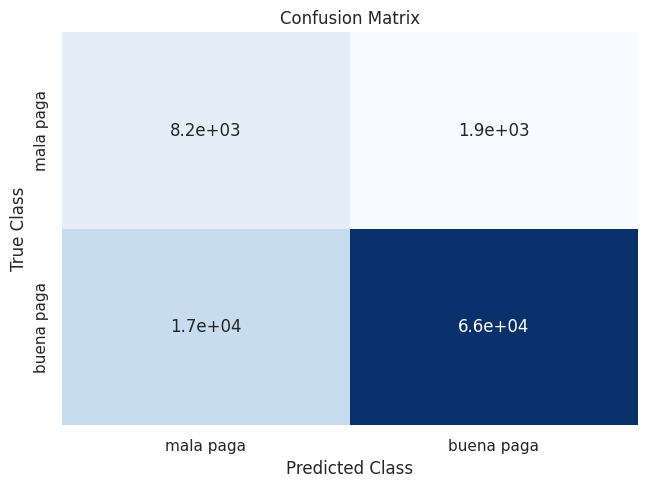

In [69]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
matrix = confusion_matrix(y_test, y_hat_test)
dataframe = pd.DataFrame(matrix, index=["mala paga","buena paga"], columns=["mala paga","buena paga"])

# crear mapa de calor dibujar mapa de calor
sns.heatmap(dataframe, annot=True, cbar=None, cmap="Blues")
plt.title("Confusion Matrix"), plt.tight_layout()
plt.ylabel("True Class"), plt.xlabel("Predicted Class")
plt.show()

Según la matriz de confusión se observa que 8200 personas fueron clasificadas correctamente como mala paga, 66000 personas fueron clasificadas correctamente como buena paga.

con estos resultados podemos obtener que la probabilidad de que alguien no cumpla con los pagos es de aproximadamente 11,05%

# Modelo scorecard

In [18]:
# create a new dataframe with one column with values from the 'reference_categories' list
df_ref_categories = pd.DataFrame(ref_categories, columns = ['Feature name'])
# We create a second column, called 'Coefficients', which contains only 0 values.
df_ref_categories['Coefficients'] = 0

# Concatenates two dataframes
df_scorecard = pd.concat([summary_table, df_ref_categories])
# reset the index
df_scorecard.reset_index(inplace = True)

# create a new column, called 'Original feature name', which contains the value of the 'Feature name' column
df_scorecard['Original feature name'] = df_scorecard['Feature name'].str.split(':').str[0]

# Define the min and max threshholds for our scorecard
min_score = 300
max_score = 850

# calculate the sum of the minimum coefficients of each category within the original feature name
min_sum_coef = df_scorecard.groupby('Original feature name')['Coefficients'].min().sum()
# calculate the sum of the maximum coefficients of each category within the original feature name
max_sum_coef = df_scorecard.groupby('Original feature name')['Coefficients'].max().sum()
# create a new column that has the imputed calculated Score based scaled from the coefficients
df_scorecard['Score - Calculation'] = df_scorecard['Coefficients'] * (max_score - min_score) / (
	max_sum_coef - min_sum_coef)
# update the calculated score of the Intercept
df_scorecard.loc[0, 'Score - Calculation'] = (
	(df_scorecard.loc[0,'Coefficients'] - min_sum_coef) /
	(max_sum_coef - min_sum_coef
	)) * (max_score - min_score) + min_score
# round the values of the 'Score - Calculation' column and store them in a new column
df_scorecard['Score - Preliminary'] = df_scorecard['Score - Calculation'].round()

# check the min and max possible scores of our scorecard
min_sum_score_prel = df_scorecard.groupby('Original feature name')['Score - Preliminary'].min().sum()
max_sum_score_prel = df_scorecard.groupby('Original feature name')['Score - Preliminary'].max().sum()
print(min_sum_score_prel)
print(max_sum_score_prel)

# so both our min and max scores are out by +1. we need to manually adjust this
# Which one? We'll evaluate based on the rounding differences of the minimum category within each Original Feature Name.
pd.options.display.max_rows = 102
df_scorecard['Difference'] = df_scorecard['Score - Preliminary'] - df_scorecard['Score - Calculation']

# look like we can get by deducting 1 from the Intercept
df_scorecard['Score - Final'] = df_scorecard['Score - Preliminary']
df_scorecard.loc[0, 'Score - Final'] = 598

# Recheck min and max possible scores
print(df_scorecard.groupby('Original feature name')['Score - Final'].min().sum())
print(df_scorecard.groupby('Original feature name')['Score - Final'].max().sum())

# calculate credit scores for test set
# first create a transformed test set through our WoE_Binning custom class
X_test_woe_transformed = woe_transform.fit_transform(X_test)
# insert an Intercept column in its beginning to align with the # of rows in scorecard
X_test_woe_transformed.insert(0, 'Intercept', 1)

# get the list of our final scorecard scores
scorecard_scores = df_scorecard['Score - Final']
# check the shapes of test set and scorecard before doing matrix dot multiplication
print(X_test_woe_transformed.shape)
print(scorecard_scores.shape)

# we can see that the test set has 17 less columns than the rows in scorecard due to the reference categories
# since the reference categories will always be scored as 0 based on the scorecard,
# it is safe to add these categories to the end of test set with 0 values
X_test_woe_transformed = pd.concat([X_test_woe_transformed, 
				    pd.DataFrame(dict.fromkeys(ref_categories, [0]
							       * len(X_test_woe_transformed)), 
						 index = X_test_woe_transformed.index)], axis = 1)
# Need to reshape scorecard_scores so that it is (102,1) to allow for matrix dot multiplication
scorecard_scores = scorecard_scores.values.reshape(102, 1)
print(X_test_woe_transformed.shape)
print(scorecard_scores.shape)

# matrix dot multiplication of test set with scorecard scores
y_scores = X_test_woe_transformed.dot(scorecard_scores)



301.0
851.0
300.0
850.0
(93257, 85)
(102,)
(93257, 102)
(102, 1)


In [19]:
import pickle
with open('model2.pkl', 'wb') as model_file:
  pickle.dump(pipeline, model_file)

In [67]:
import dill
def prediccion_riesgo(dic):
    modelo= dill.load(open("/work/model2.pkl", "rb"))
    data=pd.DataFrame(data=dic,index=[0])
    prediccion=modelo.predict_proba(data)
    return prediccion[0][1]
  
term = 48
int_rate = 5
grade = 'A'
emp_length = 1
home_ownership = 'OWN'
annual_inc = 20000
verification_status = 'Not Verified'
purpose = 'car'
dti = 10
inq_last_6mths = 8.2
revol_util = 100.22
total_acc = 50.1
out_prncp = 11681
total_pymnt = 34919
total_rec_int = 10172
last_pymnt_amnt = 6234
tot_cur_bal = 1158254
total_rev_hi_lim = 12
mths_since_earliest_cr_line = 2
mths_since_issue_d = 5
mths_since_last_pymnt_d = 3
mths_since_last_credit_pull_d = 7
grade_A = 0
grade_B = 0
grade_C = 1
grade_D = 0
grade_E = 0
grade_F = 0
grade_G = 0
home_ownership_MORTGAGE = 1
home_ownership_NONE = 0
home_ownership_OTHER = 0
home_ownership_OWN = 0
home_ownership_RENT = 0
verification_status_Not_Verified = 1
verification_status_Source_Verified = 0
verification_status_Verified = 0
purpose_car= 0
purpose_credit_card= 0
purpose_debt_consolidation= 0
purpose_educational= 0
purpose_home_improvement= 0
purpose_house= 0
purpose_major_purchase= 1
purpose_medical= 0
purpose_moving= 0
purpose_other= 0
purpose_renewable_energy= 0
purpose_small_business= 0
purpose_vacation= 0
purpose_wedding= 0
  
dic={
        'term': int(term),
        'int_rate': float(int_rate),
        'grade': str(grade),
        'emp_length':float(emp_length),
        'home_ownership': str(home_ownership),
        'annual_inc': float(annual_inc),
        'verification_status': str(verification_status),
        'purpose': str(purpose),
        'dti': float(dti),
        'inq_last_6mths': float(inq_last_6mths),
        'revol_util': float(revol_util),
        'total_acc': float(total_acc),
        'out_prncp': float(out_prncp),
        'total_pymnt': float(total_pymnt),
        'total_rec_int': float(total_rec_int),
        'last_pymnt_amnt': float(last_pymnt_amnt),
        'tot_cur_bal': float(tot_cur_bal),
        'total_rev_hi_lim': float(total_rev_hi_lim),
        'mths_since_earliest_cr_line': float(mths_since_earliest_cr_line),
        'mths_since_issue_d': float(mths_since_issue_d),
        'mths_since_last_pymnt_d':float(mths_since_last_pymnt_d),
        'mths_since_last_credit_pull_d': float(mths_since_last_credit_pull_d),
        'grade:A': grade_A,
        'grade:B': grade_B,
        'grade:C': grade_C,
        'grade:D': grade_D,
        'grade:E': grade_E,
        'grade:F': grade_F,
        'grade:G': grade_G,
        'home_ownership:MORTGAGE': home_ownership_MORTGAGE,
        'home_ownership:NONE': home_ownership_NONE,
        'home_ownership:OTHER': home_ownership_OTHER,
        'home_ownership:OWN': home_ownership_OWN,
        'home_ownership:RENT': home_ownership_RENT,
        'verification_status:Not Verified': verification_status_Not_Verified,
        'verification_status:Source Verified': verification_status_Source_Verified,
        'verification_status:Verified': verification_status_Verified,
        'purpose:car': purpose_car,
        'purpose:credit_card': purpose_credit_card,
        'purpose:debt_consolidation': purpose_debt_consolidation,
        'purpose:educational': purpose_educational,
        'purpose:home_improvement': purpose_home_improvement,
        'purpose:house': purpose_house,
        'purpose:major_purchase': purpose_major_purchase,
        'purpose:medical': purpose_medical,
        'purpose:moving': purpose_moving,
        'purpose:other': purpose_other,
        'purpose:renewable_energy': purpose_renewable_energy,
        'purpose:small_business': purpose_small_business,
        'purpose:vacation': purpose_vacation,
        'purpose:wedding': purpose_wedding,
    }
respuesta=prediccion_riesgo(dic)

print(respuesta)

0.9961611797952964
/tmp/ipykernel_334/4275606832.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_new['home_ownership:OWN'] = X.loc[:,'home_ownership:OWN']
/tmp/ipykernel_334/4275606832.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_new['home_ownership:MORTGAGE'] = X.loc[:,'home_ownership:MORTGAGE']
/tmp/ipykernel_334/4275606832.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

In [44]:
X_test_with_scores = X_test.copy()
X_test_with_scores['Cumplimiento']= y_hat_test_proba
X_test_with_scores['ScoreCard']=y_scores
X_test_with_scores.to_csv("test_with_scores.csv")

In [46]:
df_scorecard.to_csv("df_scorecard.csv")

In [55]:
X_input_caracteristicas = pd.DataFrame(dic, index=[0])
#input_caracteristicas
# first create a transformed test set through our WoE_Binning custom class
X_input_woe_transformed = woe_transform.fit_transform(X_input_caracteristicas)
# insert an Intercept column in its beginning to align with the # of rows in scorecard
X_input_woe_transformed.insert(0, 'Intercept', 1)
X_input_woe_transformed.head()

# get the list of our final scorecard scores
scorecard_scores = df_scorecard['Score - Final']
# check the shapes of test set and scorecard before doing matrix dot multiplication
print(X_input_woe_transformed.shape)
print(scorecard_scores.shape)

X_input_woe_transformed = pd.concat([X_input_woe_transformed, pd.DataFrame(dict.fromkeys(ref_categories, [0] * len(X_input_woe_transformed)), 
                                                                         index = X_input_woe_transformed.index)], axis = 1)

scorecard_scores = scorecard_scores.values.reshape(102, 1)
print(X_input_woe_transformed.shape)
print(scorecard_scores.shape)

(1, 85)
(102,)
(1, 102)
(102, 1)
/tmp/ipykernel_334/4275606832.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_new['home_ownership:OWN'] = X.loc[:,'home_ownership:OWN']
/tmp/ipykernel_334/4275606832.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_new['home_ownership:MORTGAGE'] = X.loc[:,'home_ownership:MORTGAGE']
/tmp/ipykernel_334/4275606832.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instea

In [73]:
# matrix dot multiplication of test set with scorecard scores
y_score = X_input_woe_transformed.dot(scorecard_scores)
y_score.head()

,0
0,662.0


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=2d8bceee-9d6f-499d-a2bd-fd29b704bf2c' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>